In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from random import shuffle

import gym
from collections import deque

In [3]:
env = gym.make('Freeway-ram-v0')
aspace = 3
env.env.get_action_meanings()

['NOOP', 'UP', 'DOWN']

In [16]:
def update_dist(r, support, probs, lim=(-10,10), gamma=0.8):
    nsup = probs.shape[0]
    vmin, vmax = lim[0], lim[1]
    dz = (vmax-vmin)/(nsup-1.)
    
    bin_idx = np.round((r-vmin)/dz)
    bin_idx = int(np.clip(bin_idx, 0, nsup-1))
    dist = probs.clone()
    j = 1
    for i in range(bin_idx, 1, -1):
        dist[i] += np.power(gamma, j) * dist[i-1]
        j += 1
    j = 1
    for i in range(bin_idx, nsup-1, 1):
        dist[i] += np.power(gamma, j) * dist[i+1]
        j += 1
    dist /= dist.sum()
    return dist

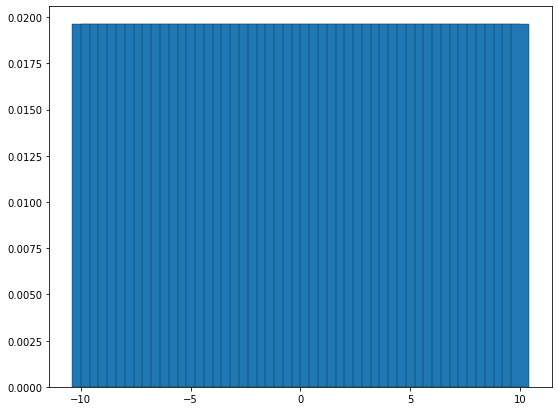

In [35]:
plt.figure(figsize=(9,7))
vmin, vmax = -10, 10
nsup = 51
support = np.linspace(vmin, vmax, nsup)
probs = np.ones(nsup)
probs /= probs.sum()

Z = torch.from_numpy(probs).float()

plt.bar(support, probs, linewidth = 0.3, edgecolor = 'k');

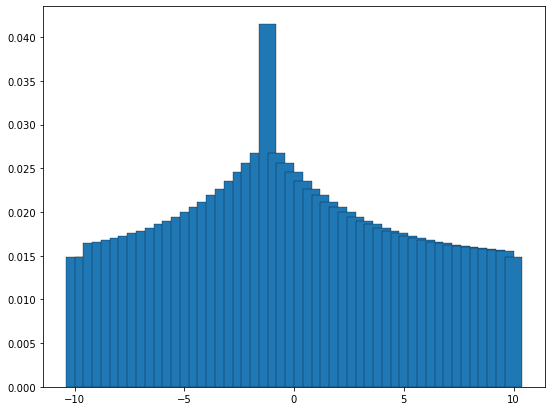

In [36]:
plt.figure(figsize=(9,7))
ob_reward = -1

Z = torch.from_numpy(probs).float()
Z = update_dist(ob_reward, torch.from_numpy(support).float(), Z, lim=(vmin,vmax), gamma=0.9)

plt.bar(support, Z, linewidth = 0.3, edgecolor = 'k');

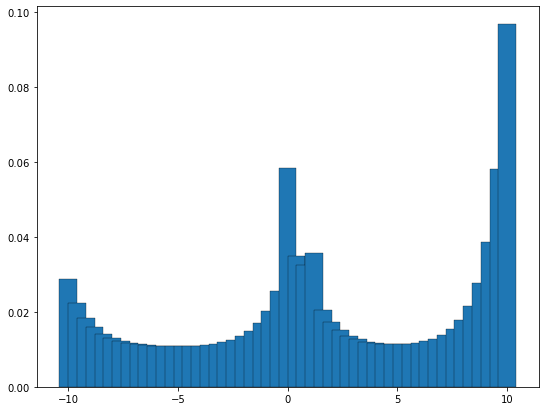

In [37]:
plt.figure(figsize=(9,7))
ob_rewards = [10,10,10,0,1,0,-10,-10,10,10]

Z = torch.from_numpy(probs).float()
for i in range(len(ob_rewards)):
    Z = update_dist(ob_rewards[i], torch.from_numpy(support).float(), Z, lim=(vmin,vmax), gamma=0.7)
    
plt.bar(support, Z, linewidth = 0.3, edgecolor = 'k');

In [50]:
def get_target_dist(dist_batch, action_batch, reward_batch, support, lim=(-10,10), gamma=0.8):
    nsup = support.shape[0]
    vmin, vmax = lim[0], lim[1]
    dz = (vmax - vmin)/(nsup-1.)
    
    target_dist_batch = dist_batch.clone()
    
    for i in range(dist_batch.shape[0]):
        dist_full = dist_batch[i] # get distribution for state (s_i)
        a = int(action_batch[i].item()) # get action a_i
        dist = dist_full[a] # distribution for P(s_i,a_i,Q)
        
        r = reward_batch[i] # transition reward (s_i,a_i,r_i,s_{i+1})
        if r != -1: # if there is no s_{i+1}, ie a terminal state
            target_dist = torch.zeros(nsup)
            bj = np.round((r-vmin)/dz)
            bj = int(np.clip(bj,0,nsup-1))
            target_dist[bj] = 1. # make P(s_i,a_i,Q) = 1 when Q = r_i and all else 0
        else:
            target_dist = update_dist(r, support, dist, lim=lim, gamma=gamma) # update P(s_i,a_i,Q) with observed r_i
        target_dist_batch[i, a, :] = target_dist # update the distro for s_i
    
    return target_dist_batch

In [41]:
def dist_dqn(x,theta,aspace=3):
    """
    3 layer neural network
    `x` is input vector of dim 128
    `theta` is a parameter vector that will be unpacked into 3 separate layer matrices
        layer1: L1 x X -> 100x128 x 128xB -> 100xB
        layer2: L2 x L1 -> 25x100 x 100xB -> 25xB
        layer3: L3 x L2 -> 3x25x51 x 25xB -> 3x51xB
        where `B` is the batch size dimension
        
    Returns a Batch Sizex A x 51 tensor where A is the action-space size
    """
    dim0 = 128
    dim1 = 100
    dim2 = 25
    dim3 = 51
    t1 = dim0*dim1
    t2 = dim2*dim1
    theta1 = theta[0:t1].reshape(dim0,dim1)
    theta2 = theta[t1:t1 + t2].reshape(dim1,dim2)
    #
    l1 = x @ theta1 #B x 128 x 128 x 100 = B x 100
    l1 = torch.selu(l1)
    l2 = l1 @ theta2 # B x 100 x 100 x 25 = B x 25
    l2 = torch.selu(l2)
    l3 = []
    for i in range(aspace):
        step = dim2*dim3
        theta5_dim = t1 + t2 + i * step
        theta5 = theta[theta5_dim:theta5_dim+step].reshape(dim2,dim3)
        l3_ = l2 @ theta5 #B x 25 x 25 x 51 = B x 51
        l3.append(l3_)
    l3 = torch.stack(l3,dim=1) # B x 3 x 51
    l3 = torch.nn.functional.softmax(l3,dim=2)
    return l3.squeeze()

In [42]:
def get_action(dist,support):
    """
    This function returns an integer action in [0,1,2]
    `dist` input is a Ax51xB discrete distribution over Q-values for each action
    where `A` is the action-space size, and `B` is the batch dimension.
    Get expectations w.r.t. to each action, take action w/ highest q-value
    
    Output:
    - `actions`: vector of integers in {0,1,2}, dimension dist.shape[0] (batch size)
    """
    actions = []
    for b in range(dist.shape[0]): #loop through batch dimension
        expectations = [support @ dist[b,a,:] for a in range(dist.shape[1])]
        action = int(np.argmax(expectations))
        actions.append(action)
    actions = torch.Tensor(actions).int()
    return actions

In [43]:
def lossfn(x,y):
    """
    Cross-Entropy Loss between prediction distribution `x` and target distribution `y`
    `x`: B x A x 51 tensor where `B` is batch dimension, `A` is action dimension
    `y` is B x A x 51 tensor
    
    Output
    - `loss`: Float
    """
    loss = torch.Tensor([0.])
    loss.requires_grad=True
    for i in range(x.shape[0]): #loop through batch dimension
        loss_ = -1 *  torch.log(x[i].flatten(start_dim=0)) @ y[i].flatten(start_dim=0)
        loss = loss + loss_
    return loss

def preproc_state(state):
    """
    Takes numpy array from env.reset or env.step
    and converts to PyTorch Tensor, adds batch dimension and normalizes
    
    Output:
    - `p_state`: PyTorch tensor of dimensions 1x128
    """
    p_state = torch.from_numpy(state).unsqueeze(dim=0).float()
    p_state = torch.nn.functional.normalize(p_state,dim=1)
    #
    return p_state

In [54]:
#Initialize DQN parameter vector
aspace = 3
tot_params = 128*100 + 25*100 + aspace*25*51
theta = torch.randn(tot_params)/10.
theta.requires_grad=True
theta_2 = theta.detach().clone() #initialize paramaters for target network


vmin,vmax= -10,10
gamma=0.9
lr = 0.00001
update_rate = 75

support = torch.linspace(-10,10,51)
state = torch.randn(2,128)/10.

action_batch = torch.Tensor([0,2])
reward_batch = torch.Tensor([0,8]) + torch.randn(2)/10.0

losses = []

pred_batch = dist_dqn(state, theta, aspace=aspace) # P(s_i,a,Q)

# current estimates for P(s_i,a,Q), (a_i), (r_i)
target_dist = get_target_dist(pred_batch,action_batch,reward_batch,
                              support, lim=(vmin,vmax),gamma=gamma)

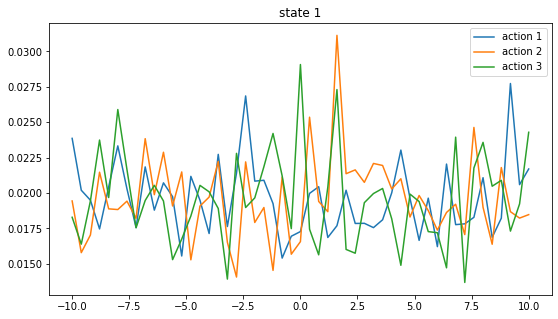

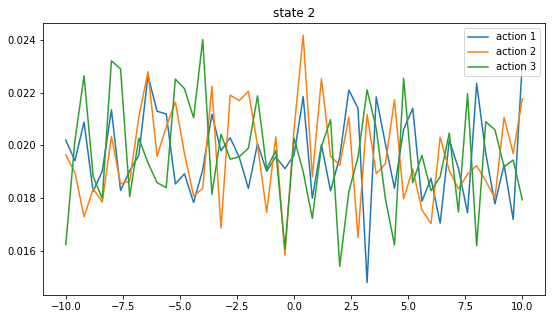

In [66]:
for s in range(len(state)):
    plt.figure(figsize=(9,5))
    for a in range(aspace):
        plt.plot(support, pred_batch[s,a].data.numpy(), label="action %d"%(a+1))
    plt.legend();
    plt.title("state %d"%(s+1))
    plt.show()

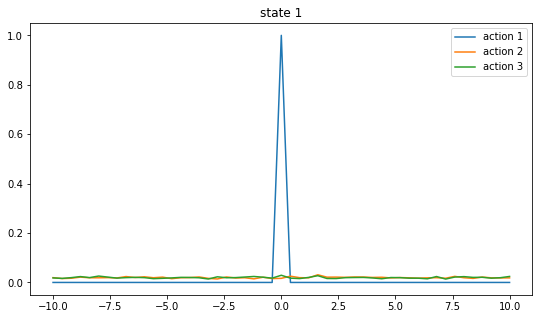

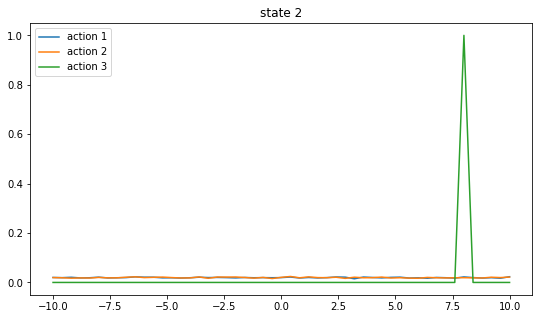

In [67]:
for s in range(len(state)):
    plt.figure(figsize=(9,5))
    for a in range(aspace):
        plt.plot(support, target_dist[s,a].data.numpy(), label="action %d"%(a+1))
    plt.legend();
    plt.title("state %d"%(s+1))
    plt.show()

In [68]:
# R(s_1, 0, Q), local reward = 0
# R(s_2, 2, Q), local reward = 10

In [ ]:
for i in range(1000):
    # simulate stochastic rewards
    reward_batch = torch.Tensor([0,8]) + torch.randn(2)/10.0 #add some random noise to rewards to make it harder
    
    pred_batch = dist_dqn(state,theta,aspace=aspace)
    pred_batch2 = dist_dqn(state,theta_2,aspace=aspace)
    
    target_dist = get_target_dist(pred_batch2,action_batch,reward_batch, \
                                 support, lim=(vmin,vmax),gamma=gamma)
    
    loss = lossfn(pred_batch,target_dist.detach())
    losses.append(loss.item())
    loss.backward()
    
    # Gradient Descent
    with torch.no_grad():
        theta -= lr * theta.grad
    theta.requires_grad = True
    
    if i % update_rate == 0: #sync target network parameters with main model parameters
        theta_2 = theta.detach().clone()